# Implementation of RNNs from scratch

Now we will implement a language model based on a character-level RNN trained on H. G. Wells’ *The Time Machine*. We start by reading the data set first

In [1]:
import utils
import torch
import math
import d2l

In [2]:
batch_size, num_steps = 32, 35
train_iter, vocab = utils.load_data_time_machine(batch_size,
                                                num_steps)

In [3]:
sample = next(train_iter.get_iter())

In [4]:
sample[0].shape

torch.Size([32, 35])

## One-hot Encoding

Remember that each token is presented as a numerical index in ``train_iter``. Feeding these indices directly to the neural network might make it hard to learn. We often present each token as a more expressive feature vector. The easiest presentation is called ``one-hot encoding``.

In a nutshell, we map each index to a different unit vector: assume that the number of different tokens in the vocabulary is N (the ``len(vocab)``) and the token indices range from 0 to N-1. If the index of a token is the integer i , then we create a vector $\mathbf{e}_i$ of all 0s with a length of N and set the element at position i to 1. This vector is the one-hot vector of the original token. The one-hot vectors with indices 0 and 2 are shown below.

In [5]:
x = torch.tensor([0, 2])
x_one_hot = torch.nn.functional.one_hot(x, len(vocab))

In [6]:
x_one_hot

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

The shape of the mini-batch we sample each time is (batch size, time step). The ``one_hot`` function transforms such a mini-batch into a 3-D tensor with the last dimension equals to the vocabulary size. We often transpose the input so that we will obtain a (time step, batch size, vocabulary size) output that fits into a sequence
model easier.

In [7]:
# type your code here
X = torch.arange(10).reshape(2, 5)
torch.nn.functional.one_hot(X.T, len(vocab)).shape

torch.Size([5, 2, 28])

## Initializing the Model Parameters

Next, we initialize the model parameters for a RNN model. The number of hidden units ``num_hiddens`` is a tunable parameter.

In [8]:
def get_params(vocab_size, num_hiddens):
    num_inputs = num_outputs = vocab_size
    # Hidden layer parameters
    normal = lambda shape: 0.01*torch.randn(size=shape)
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens)
    # Output layer parameters
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs)
    # Attach a gradient
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params: 
        param.requires_grad = True
    return params

In [11]:
params = get_params(28, 3)

In [12]:
params[0].shape

torch.Size([28, 3])

## RNN Model

First, we need an ``init_rnn_state`` function to return the hidden state at initialization. It returns a tuple consisting of a tensor with a value of 0 and a shape of (batch size, number of hidden units). Using tuples makes it easier to handle situations where the hidden state contains multiple variables (e.g. when combining multiple layers in an RNN where each layers requires initializing).

In [13]:
def init_rnn_state(batch_size, num_hiddens):
    return (torch.zeros(size=(batch_size, num_hiddens)), )

The following ``rnn`` function defines how to compute the hidden state and output in a time step. The activation function here uses the ``tanh`` function.

In [14]:
def rnn(inputs, state, params):
    # inputs shape: (num_steps, batch_size, vocab_size)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    # type your code here
    outputs = []
    for X in inputs:
        H = torch.tanh( torch.matmul(X.type(torch.FloatTensor), W_xh) + 
                      torch.matmul(H, W_hh) + b_h)
        Y = torch.matmul(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, )

Now we have all functions defined, next we create a class to wrap these functions and store parameters.

In [24]:
class RNNModelScratch(object):
    """A RNN Model based on scratch implementations"""
    def __init__(self, vocab_size, num_hiddens, get_params, init_state, forward):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens)
        self.init_state, self.forward_fn = init_state, forward
    def __call__(self, X, state):
        X = torch.nn.functional.one_hot(X.transpose(0,-1), self.vocab_size)
        return self.forward_fn(X, state, self.params)
    def begin_state(self, batch_size):
        return self.init_state(batch_size, self.num_hiddens)

Let’s do a sanity check whether inputs and outputs have the correct dimensions, e.g. to ensure that the dimensionality of the hidden state hasn’t changed.

In [25]:
X

tensor([[0, 1, 2, 3, 4],
        [5, 6, 7, 8, 9]])

In [26]:
vocab_size, num_hiddens = len(vocab), 512
model = RNNModelScratch(vocab_size, num_hiddens, get_params,
                        init_rnn_state, rnn)
state = model.begin_state(X.shape[0])
Y, new_state = model(X, state)
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

We can see that the output shape is (number steps x batch size, vocabulary size), while the state shape remains the same, i.e. (batch size, number of hidden units).

## Prediction

We first explain the predicting function so we can regularly check the prediction during training. This function predicts the next ``num_predicts`` characters based on the prefix (a string containing several characters). For the beginning of the sequence, we only update the hidden state. After that we begin generating new characters and emitting them.

In [27]:
def predict_rnn(prefix, num_predicts, model, vocab):
    state = model.begin_state(batch_size=1)
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]]).reshape((1, 1))
    for y in prefix[1:]: # Warmup state with prefix
        _, state = model(get_input(), state)
        outputs.append(vocab[y])
    for _ in range(num_predicts): # Predict num_predicts steps
        Y, state = model(get_input(), state)
        outputs.append(int(Y.argmax(dim=1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

We test the ``predict_rnn`` function first. Given that we didn’t train the network it will generate nonsensical predictions. We initialize it with the sequence traveller and have it generate 10 additional characters.

In [29]:
predict_rnn('time traveller ', 10, model, vocab)

'time traveller vpq vpq vp'

## Gradient Clipping

For a sequence of length T, we compute the gradients over these T time steps in an iteration, which results in a chain of matrix-products with length $O(T)$ during backpropagating. As we mentioned before, it might result in numerical instability, e.g. the gradients may either explode or vanish, when T is large. Therefore RNN models often need extra help to stabilize the training.

Sometimes the gradients can be quite large and the optimization algorithm may fail to converge. We could address this by reducing the learning rate $\eta$ or by some other higher order trick. But what if we only rarely get large gradients? In this case such an approach may appear entirely unwarranted. One alternative is to
clip the gradients by projecting them back to a ball of a given radius, say $\theta$ via $$\mathbf{g} \leftarrow \min\left(1, \frac{\theta}{\|\mathbf{g} \|} \right) \mathbf{g}$$.

By doing so we know that the gradient norm never exceeds $\theta$ and that the updated gradient is entirely aligned with the original direction $\mathbf{g}$. This bestows a certain degree of robustness to the model. Gradient clipping provides a quick fix to the gradient exploding. While it doesn’t entirely solve the problem, it is one of the many techniques to alleviate it.

Below we define a function to clip the gradients of a model. Note that we compute the gradient norm over all parameters.

In [30]:
def grad_clipping(model, theta):
    params = model.params
    norm = math.sqrt(sum(sum(p.grad.data**2) for p in params))
    if norm > theta:
        for param in params:
            param.grad.data *= theta/norm

## Training

Let’s first define the function to train the model on one data epoch. It differs to the
models training from previous chapters in three places:

* Different sampling methods for sequential data (random sampling and sequential partitioning) will result in differences in the initialization of hidden states.

* We clip the gradient before updating the model parameters. This ensures that the model doesn’t diverge even when gradients blow up at some point during the training process (effectively it reduces the stepsize automatically).

* We use perplexity to evaluate the model. This ensures that different tests are comparable.

When the consecutive sampling is used, we initialize the hidden state at the beginning of each epoch. Since the i-th example in the next mini-batch is adjacent to the current i-th example, so the next mini-batch can use the current hidden state directly, we only detach the gradient so that we only compute the gradients within a mini-batch. When using the random sampling, we need to re-initialize the hidden state for each iteration since each example is sampled with a random position.

In [40]:
def train_epoch_rnn(model, train_iter, loss, updater, use_random_iter):
    state, timer = None, d2l.Timer()
    metric = utils.Accumulator(2) # loss_sum, num_examples
    for X, Y in train_iter:
        if state is None or use_random_iter:
            # Initialize state when either it's the first iteration or
            # using random sampling.
            state = model.begin_state(batch_size=X.shape[0])
        else:
            for s in state: 
                s.detach_()
        y = Y.T.reshape((-1,))
        py, state = model(X, state)
        l = loss(py, y)
        updater.zero_grad()
        l.backward()
        grad_clipping(model, 1)
        updater.step()
        l_sum = float(l)*len(y)
        metric.add(l_sum, len(y))
    return math.exp(metric[0]/metric[1]), metric[1]/timer.stop()
# def train_epoch_rnn(model, train_iter, loss, updater, use_random_iter):
#     state, timer = None, d2l.Timer()
#     metric = utils.Accumulator(2) # loss_sum, num_examples
#     for X, Y in train_iter:
#         if state is None or use_random_iter:
#             # Initialize state when either it's the first iteration or
#             # using random sampling.
#             state = model.begin_state(batch_size=X.shape[0])
#         else:
#             for s in state: 
#                 # type your code here
#                 s.detach_()
#         y = Y.T.reshape((-1, 1))
#         py, state = model(X, state)
#         l = loss(py, y)
#         updater.zero_grad()
#         l.backward()
#         grad_clipping(model, 1)
#         updater.step()
#         l_sum = float(l)*len(y)
#         metric.add(l_sum, len(y))       
#     return math.exp(metric[0]/metric[1]), metric[1]/timer.stop()

In [41]:
def train_rnn(model, train_iter, vocab, lr, num_epochs, use_random_iter=False):
    loss = torch.nn.CrossEntropyLoss()
    animator = utils.Animator(xlabel='epoch', ylabel='perplexity',
                             legend=['train'], xlim=[1, num_epochs])
    updater = torch.optim.SGD(model.params, lr=lr)
    predict = lambda prefix: predict_rnn(prefix, 50, model, vocab)
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_rnn(model, train_iter, loss,
                                    updater, use_random_iter)
        if epoch % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch+1, [ppl])
            
    print('Perplexity %.1f, %d tokens/sec' % (ppl, speed))
    print(predict('time traveller'))
    print(predict('traveller'))

Finally we can train a model. Since we only use 10,000 tokens in the dataset, so here we need more data epochs to converge.

RuntimeError: The size of tensor a (512) must match the size of tensor b (28) at non-singleton dimension 0

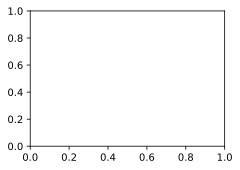

In [42]:
num_epochs, lr = 500, 1
train_rnn(model, train_iter, vocab, lr, num_epochs)